## Aim:
* To find the impact of financial aid on college dropout rate

## Variables:

1. Dropput index : Higher the value lower the dropout.
2. family_indx : Higher the value higher is the need to acquire financial aid
3. w1 : Some exogenous factor that impacts dropout
4. w1 : some other exogenous factor that impacts dropout

## Idea:

* To measure the impact of college dropout in students with respect to the provision of financial aid.

In [5]:
import pandas as pd
import numpy as np
import rdd as rdd # https://pypi.org/project/rdd

PLEASE NOTE : THIS FUNCTIONS BELOW ARE A PART OF THE PYPI LIBRARY NAMED "RDD".WE HAVE EXPLICITLY DEFINED THE FUNCTION HERE 
DUE TO SOME ISSUE IN CALLING DIRECTLY FROM THE LIBRARY.
THE TUTORIAL USES SAME TEMPLATE AS PROVIDED IN THE RDD LIBRARY.
Courtsey : 
#### https://pypi.org/project/rdd

In [6]:
import statsmodels.formula.api as smf


def optimal_bandwidth(Y, X, cut=0):
    '''
    DESCRIPTION:
        For a given outcome Y and running variable X, computes the optimal bandwidth
        h using a triangular kernel. For more information, see 
        "OPTIMAL BANDWIDTH CHOICE FOR THE REGRESSION DISCONTINUITY ESTIMATOR",
        by Imbens and Kalyanaraman, at http://www.nber.org/papers/w14726.pdf

    INPUTS:
        Two equal length pandas Series
            Y: the outcome variable
            X: the running variable
        cut: value for the threshold of the rdd (scalar) (default is 0)
    
    OUTPUTS:
        Scalar optimal bandwidth value
    '''

    assert(X.shape[0] == Y.shape[0], "X and Y are not of the same length")
    assert(np.sum(pd.isnull(X)) == 0, "NaNs are present in the running variable X")
    assert(np.sum(pd.isnull(Y)) == 0, "NaNs are present in the running variable X")


    # Normalize X
    X = X - cut

    # Step 1
    h1 = 1.84 * X.std() * (X.shape[0]**(-.2))
    Nh1neg = X[(X < 0) & (X > -h1)].shape[0]
    Nh1pos =X[(X >= 0) & (X < h1)].shape[0]
    Ybarh1neg = Y[(X < 0) & (X > -h1)].mean()
    Ybarh1pos = Y[(X >= 0) & (X < h1)].mean()
    fXc = (Nh1neg + Nh1pos) / (2 * X.shape[0] * h1)
    sig2c = (((Y[(X < 0) & (X > -h1)]-Ybarh1neg)**2).sum() +((Y[(X >= 0) & (X < h1)]-Ybarh1pos)**2).sum()) / (Nh1neg + Nh1pos)
    
    # Step 2
    medXneg = X[X<0].median()
    medXpos = X[X>=0].median()
    dat_temp = pd.DataFrame({'Y': Y,'X':X})
    dat_temp = dat_temp.loc[(dat_temp['X'] >= medXneg) & (dat_temp['X'] <= medXpos)]
    dat_temp['treat'] = 0
    dat_temp.loc[dat_temp['X'] >= 0, 'treat'] = 1
    dat_temp['X2'] = X**2
    dat_temp['X3'] = X**3
    eqn = 'Y ~ 1 + treat + X + X2 + X3'
    results = smf.ols(eqn, data=dat_temp).fit()
    m3 = 6*results.params.loc['X3']
    h2pos = 3.56 * (X[X>=0].shape[0]**(-1/7.0)) * (sig2c/(fXc * np.max([m3**2, .01]))) ** (1/7.0)
    h2neg = 3.56 * (X[X<0].shape[0]**(-1/7.0)) * (sig2c/(fXc * np.max([m3**2, .01]))) ** (1/7.0)
    Yplus = Y[(X>=0) & (X<=h2pos)]
    Xplus = X[(X>=0) & (X<=h2pos)]
    dat_temp = pd.DataFrame({'Y': Yplus,'X':Xplus})
    dat_temp['X2'] = X**2
    eqn = 'Y ~ 1 + X + X2'
    results = smf.ols(eqn, data=dat_temp).fit()
    m2pos = 2*results.params.loc['X2']
    Yneg = Y[(X<0) & (X>=-h2neg)]
    Xneg = X[(X<0) & (X>=-h2neg)]
    dat_temp = pd.DataFrame({'Y': Yneg,'X':Xneg})
    dat_temp['X2'] = X**2
    eqn = 'Y ~ 1 + X + X2'
    results = smf.ols(eqn, data=dat_temp).fit()
    m2neg = 2*results.params.loc['X2']
    
    # Step 3
    rpos = 720*sig2c / (X[(X>=0) & (X<=h2pos)].shape[0] * h2pos**4)
    rneg = 720*sig2c / (X[(X<0) & (X>=-h2neg)].shape[0] * h2neg**4)
    CK = 3.4375
    hopt = CK * (2*sig2c/(fXc * ((m2pos - m2neg)**2 + (rpos+rneg))))**.2 * Y.shape[0]**(-.2)
    
    return hopt


def truncated_data(data, xname, bandwidth=None, yname=None, cut=0):
    '''

    Drop observations from dataset that are outside 
        a given (or optimal) bandwidth

    INPUTS:
        data: data with the X and Y values (pandas DataFrame)
        xname: Name of your running variable (string)
        bandwidth: Bandwidth (scalar) (if None given, the optimal bandwidth is computed)
        yname: The name of your outcome variable (string) (only needed if no bandwidth is given)
        cut: The value of your threshold (scalar) (default is 0)

    OUTPUTS:
        pandas DataFrame with observations outside of the bandwidth dropped
    
    '''
    if bandwidth==None:
        if yname==None:
            raise NameError("You must supply either a bandwidth or the name of your outcome variable.")
        else:
            bandwidth = optimal_bandwidth(data[yname], data[xname], cut=cut)
    data_new = data.loc[np.abs(data[xname]-cut)<=bandwidth, ]
    return data_new


def rdd(input_data, xname, yname=None, cut=0, equation=None, controls=None, noconst=False, weights=1, verbose=True):
    '''
    This function implements a linear regression (ordinary or weighted least squares can be used) for 
        the estimation of regressing the outcome variable on the running variable.  A "TREATED" variable
        is created, the coefficient on which is the causal effect of being to the right of the threshold.

        The user may specify a list of controls to be added linearly, or supply their own equation.  

    INPUT:
        input_data: dataset with outcome and running variables (and potentially controls) (pandas DataFrame)
        xname: name of running variable (string)
        yname: name of outcome variable (string) (default is None - not needed if you include your own equation)
        cut: location of threshold in xname (scalar) (default is 0)
        equation: Estimation equation as a string (see Statsmodels formula syntax for more info)
        controls: List of controls to include in the estimation (list of strings) (not needed if you include your own equation)
        noconst: If True, model does not estimate an intercept (bool) (default is false)
        weights: Weights for weighted least squares (numpy array) (default is equal weights, ie OLS)

    OUTPUT:
        Statsmodels object

    '''
    if yname==None and equation==None:
        raise NameError("You must supply either a outcome variable name or an equation to estimate.")
    if 'TREATED' in input_data.columns:
        raise NameError("TREATED is a reserved column name.  Please change the name.")
    data = input_data.copy() # To avoid SettingWithCopy warnings
    data['TREATED'] = np.where(data[xname] >= cut, 1, 0)
    if equation==None:
        equation = yname + ' ~ TREATED + ' + xname
        if controls != None:
            equation_controls = ' + '.join(controls)
            equation += ' + ' + equation_controls
    if noconst==True:
        equation += ' -1'
    if verbose==True:
        print('Estimation Equation:\t', equation)
    rdd_model = smf.wls(equation, data=data, weights=weights)
    return rdd_model


def bin_data(data, yname, xname, bins=50, agg_fn=np.mean):
    '''
    When datasets are so large that traditional RDD scatter plots are difficult to read, 
        this will group observations by their X values into a set number of bins and compute
        the mean outcome value in that bin.  

    INPUT:
        data: dataset (pandas DataFrame)
        yname: Name of outcome variable (string)
        xname: Name of running variable (string)
        bins: Desired number of bins to group data by (integer) (default is 50)

    OUTPUT:
        A pandas DataFrame that has a row for each bin with columns:
            yname: The average value of the outcome variable in that bin
            xname: the midpoint value of the running variable in that bin
            n_obs: The number of observations in this bin
            
    '''
    hist, edges = np.histogram(data[xname], bins=bins)
    bin_midpoint = np.zeros(edges.shape[0]-1)
    binned_df = pd.DataFrame(np.zeros((edges.shape[0]-1, 1)))
    for i in range(edges.shape[0]-1):
        bin_midpoint[i] = (edges[i] + edges[i+1]) / 2
        if i < edges.shape[0]-2:
            dat_temp = data.loc[(data[xname] >= edges[i]) & (
                data[xname] < edges[i+1]), :]
            binned_df.loc[binned_df.index[i], yname] = agg_fn(dat_temp[yname])
            binned_df.loc[binned_df.index[i], xname] = bin_midpoint[i]
            binned_df.loc[binned_df.index[i], 'n_obs'] = dat_temp.shape[0]
        else:
            dat_temp = data.loc[(data[xname] >= edges[i]) & (
                data[xname] <= edges[i+1]), :]
            binned_df.loc[binned_df.index[i], yname] = agg_fn(dat_temp[yname])
            binned_df.loc[binned_df.index[i], xname] = bin_midpoint[i]
            binned_df.loc[binned_df.index[i], 'n_obs'] = dat_temp.shape[0]
    return binned_df

<>:22: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:24: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:22: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:24: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:22: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:24: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-6-a261ce6e7e8a>:22: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(X.shape[0] == Y.shape[0], "X and Y are not of the same length")
<ipython-input-6-a261ce6e7e8a>:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(np.sum(pd.isnull(X)) == 0,

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [40]:
np.random.seed(66)

In [41]:
# N = 10000
# x = np.random.normal(1, 1, N)
# epsilon = np.random.normal(0, 1, N)
# threshold = 1
# treatment = np.where(x >= threshold, 1, 0)
# x1 = np.random.normal(0, 1, N)
# x2 = np.random.normal(0, 4, N)
# y = .5 * treatment + 2 * x - .2 * x1 + 1 + epsilon

# df = pd.DataFrame({'dropout_indx':y, 'family_indx': x, 'x1':x1, 'x2':x2})
# #data['treatment'] = treatment
# df.head()

In [50]:
N = 10000
x = np.random.normal(10, 10, N)
epsilon = np.random.normal(0, 10, N)
threshold = 10
treatment = np.where(x >= threshold, 10, 0)
x1 = np.random.normal(0, 10, N)
x2 = np.random.normal(0, 40, N)
y = .25 * treatment + 2.2 * x - .25 * x1 + 1 + epsilon

df = pd.DataFrame({'dropout_indx':y, 'family_indx': x, 'x1':x1, 'x2':x2})
#data['treatment'] = treatment
df.head()

,dropout_indx,family_indx,x1,x2
0,1.734817,5.691499,5.569726,-55.469244
1,27.801635,19.038766,19.992716,45.889090
2,35.335733,10.642042,2.828464,-23.181734
3,51.182662,21.371887,-9.110498,56.806014
4,29.621661,15.496821,-1.978229,19.030710


#### We see a strong correlation between family index and how drop out is being indexed. 
#### This tells us that the way financial aid has been applied to students based on certain criteria of family wealth.
#### This further begs the following questions:
* are students similar or different in observed or unobserved ways based on certain criteria of a certain variable.
* is the variable "family_indx" solely responsible for giving financial aid, in this case the treatment variable?

In [51]:
print("we also see that the running variable and the dropout_indx has a very strong correlation")
df['dropout_indx'].corr(df['family_indx'])

we also see that the running variable and the dropout_indx has a very strong correlation


0.9125539580165342

## Finding the right subset of the data. 

##### *The right boundary around the threshold*

*OPTIMAL BANDWIDTH CHOICE FOR THE REGRESSION DISCONTINUITY ESTIMATOR by Guido Imbens Karthik Kalyanaraman* is implemented in the rdd library

This is important for us to decide the data we want to consider for the exercise

In [52]:
optimized_bandwitdh = optimal_bandwidth(df['dropout_indx'], df['family_indx'], cut=threshold)
print("Optimal bandwidth around the threshold:", optimized_bandwitdh)

Optimal bandwidth around the threshold: 5.543292668387107


we will create a subset of data that holds the threshold and the bandwitdh defined above. 

The library "rdd" has a function that does the same for us and we will go on to do the same.

In [53]:
df_rdd = truncated_data(df, 'family_indx', optimized_bandwitdh, cut=threshold)

#### How do we measure and see discontinuity ?

We know here, that discontinuity is brought into the data because of a certain variable that can impact the treatment. The variable we are talking about is called the "running variable". In our example, we see that the variable "family_indx", or in this case the variable that defines family wealth, is the running variable.

It always helps to bin the dat for better visual treat

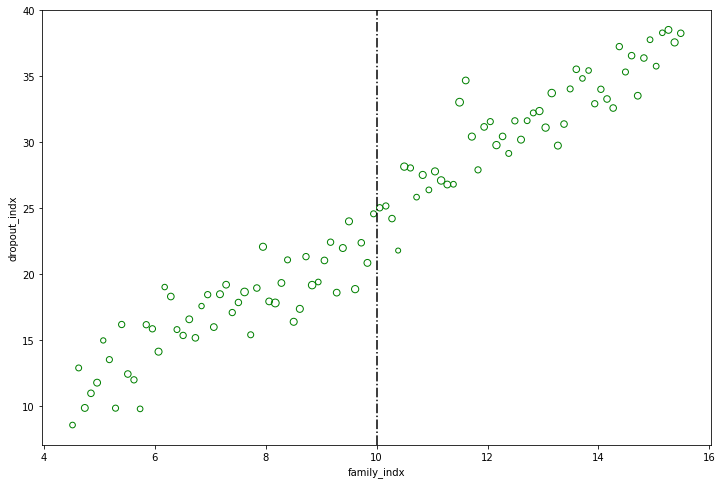

In [54]:
data_binned = bin_data(df_rdd, 'dropout_indx', 'family_indx', 100)
plt.figure(figsize=(12, 8))
plt.scatter(data_binned['family_indx'], data_binned['dropout_indx'],
    s = data_binned['n_obs'], facecolors='none', edgecolors='g')
plt.axvline(x=threshold, color='black',linestyle = 'dashdot')
plt.xlabel('family_indx')
plt.ylabel('dropout_indx')
plt.show()
plt.close()


#### Regression to calculate the Lift
We run an ols (it's a wls with weight as 1), and see how the treated variable show as estimates. We do see the treated variable to have an estimate much closer to the actual lift.

#### The Regression below shows the impact of the treated to be somewhat around 2.59 in the whole data. 
#### The data that is not restricted

In [56]:
model = rdd(df, 'family_indx', 'dropout_indx',cut = threshold)
print(model.fit().summary())

Estimation Equation:	 dropout_indx ~ TREATED + family_indx
                            WLS Regression Results                            
Dep. Variable:           dropout_indx   R-squared:                       0.834
Model:                            WLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                 2.506e+04
Date:                Thu, 29 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:33:48   Log-Likelihood:                -37450.
No. Observations:               10000   AIC:                         7.491e+04
Df Residuals:                    9997   BIC:                         7.493e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

### Once we add the control variables and use the restricted data around the threshold with the optimal bandwitdh,we see relatively a more pronounced impact of the treatment (2.93). There could be situation where the impact could be much more pronounced than what we see here.

In [57]:
model = rdd(df_rdd, 'family_indx', 'dropout_indx', cut=threshold, controls=['x1', 'x2'])
print(model.fit(cov_type='hc1').summary())

Estimation Equation:	 dropout_indx ~ TREATED + family_indx + x1 + x2
                            WLS Regression Results                            
Dep. Variable:           dropout_indx   R-squared:                       0.415
Model:                            WLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     743.7
Date:                Thu, 29 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:33:51   Log-Likelihood:                -15630.
No. Observations:                4209   AIC:                         3.127e+04
Df Residuals:                    4204   BIC:                         3.130e+04
Df Model:                           4                                         
Covariance Type:                  hc1                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

In [62]:
print("Then we try out an interaction term")
model = rdd(df_rdd, 'family_indx', cut=threshold, equation='dropout_indx ~ TREATED + family_indx + x1*x2')
print(model.fit().summary())

Then we try out an interaction term
Estimation Equation:	 dropout_indx ~ TREATED + family_indx + x1*x2
                            WLS Regression Results                            
Dep. Variable:           dropout_indx   R-squared:                       0.415
Model:                            WLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     596.3
Date:                Thu, 29 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:39:04   Log-Likelihood:                -15629.
No. Observations:                4209   AIC:                         3.127e+04
Df Residuals:                    4203   BIC:                         3.131e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

#### Validations can be done in the following ways:
* use multiple alternate threshold instead of a real threshold and see if we see any significant impaact of the treatment. If we see, then that could potentially be a red flag.

However, there could be other unobserved running variable impact to such a validation 
and it should be used as an indication.